In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from safetensors.torch import save_model, load_model


In [2]:
batch_size = 256

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad((2, 2, 2, 2)),
    transforms.Normalize((.0,), (1.0,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


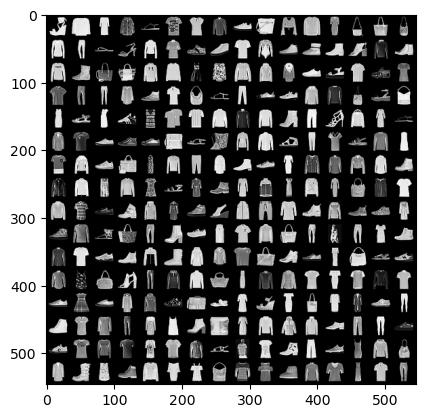

In [4]:
# Function to show an image
def imshow(img):
    plt.imshow(img.cpu().permute(1, 2, 0).numpy())
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images, nrow=16))

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 2, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
        self.relu3 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 4 * 4, 2)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


In [6]:
encoder = Encoder().cuda()

summary(encoder, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
           Flatten-7                 [-1, 2048]               0
            Linear-8                    [-1, 2]           4,098
Total params: 96,770
Trainable params: 96,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 0.37
Estimated Total Size (MB): 0.61
----------------------------------------------------------------


In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()        
        self.fc = nn.Linear(2, 2048)
        self.unflatten = nn.Unflatten(1, (128, 4, 4))
        self.convt1 = nn.ConvTranspose2d(128, 128, 3, 2, 1, 1)
        self.relu1 = nn.ReLU()
        self.convt2 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.relu2 = nn.ReLU()
        self.convt3 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.relu3 = nn.ReLU()
        self.conv = nn.Conv2d(32, 1, 3, 1, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc(x)
        x = self.unflatten(x)
        x = self.convt1(x)
        x = self.relu1(x)
        x = self.convt2(x)
        x = self.relu2(x)
        x = self.convt3(x)
        x = self.relu3(x)
        x = self.conv(x)
        x = self.sigmoid(x)
        return x

In [8]:
decoder = Decoder().cuda()
summary(decoder, (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]           6,144
         Unflatten-2            [-1, 128, 4, 4]               0
   ConvTranspose2d-3            [-1, 128, 8, 8]         147,584
              ReLU-4            [-1, 128, 8, 8]               0
   ConvTranspose2d-5           [-1, 64, 16, 16]          73,792
              ReLU-6           [-1, 64, 16, 16]               0
   ConvTranspose2d-7           [-1, 32, 32, 32]          18,464
              ReLU-8           [-1, 32, 32, 32]               0
            Conv2d-9            [-1, 1, 32, 32]             289
          Sigmoid-10            [-1, 1, 32, 32]               0
Total params: 246,273
Trainable params: 246,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.92
Params size (MB): 0.94
Estimated T

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

In [10]:
model = Autoencoder().cuda()
summary(model, (1, 32, 32))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
           Flatten-7                 [-1, 2048]               0
            Linear-8                    [-1, 2]           4,098
           Encoder-9                    [-1, 2]               0
           Linear-10                 [-1, 2048]           6,144
        Unflatten-11            [-1, 128, 4, 4]               0
  ConvTranspose2d-12            [-1, 128, 8, 8]         147,584
             ReLU-13            [-1, 128, 8, 8]               0
  ConvTranspose2d-14           [-1, 64,

In [11]:
num_epochs = 3

for epoch in range(num_epochs):
    for imgs, labels in train_loader:
        imgs, labels = imgs.cuda(), labels.cuda()  
        output = model(imgs)
        loss = criterion(output, imgs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/3], Loss: 0.3557
Epoch [2/3], Loss: 0.2941
Epoch [3/3], Loss: 0.2800


In [12]:
save_model(model, "data/autoencoder.safetensors")

In [13]:
model = Autoencoder().cuda()

In [14]:
load_model(model, "data/autoencoder.safetensors")

(set(), [])

In [15]:
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
test_x, test_label = next(iter(test_loader))
test_x = test_x.cuda()
test_y = model(test_x)

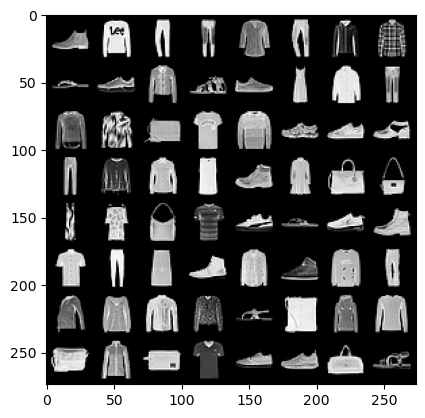

In [16]:
imshow(torchvision.utils.make_grid(test_x[:64]))

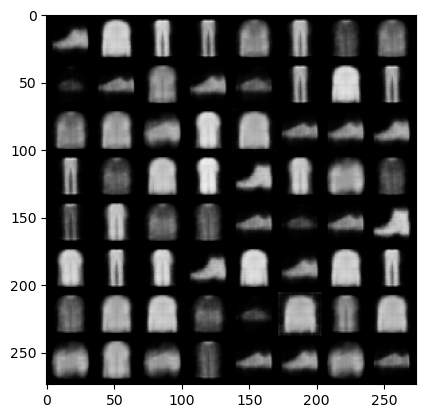

In [17]:
imshow(torchvision.utils.make_grid(test_y[:64]))

In [18]:
with torch.no_grad():
    embeddings = model.encoder(test_x).cpu()

In [19]:
print(embeddings[:10])

tensor([[ -2.5936,  14.6510],
        [ -5.3931,   0.5124],
        [-19.9249,  10.8044],
        [-19.9514,  13.2062],
        [ -4.5778,   4.9305],
        [-15.4745,   9.1198],
        [-10.5098,  10.7035],
        [ -6.2886,   6.4837],
        [-13.1678,  20.4222],
        [ -6.6052,  17.7435]])


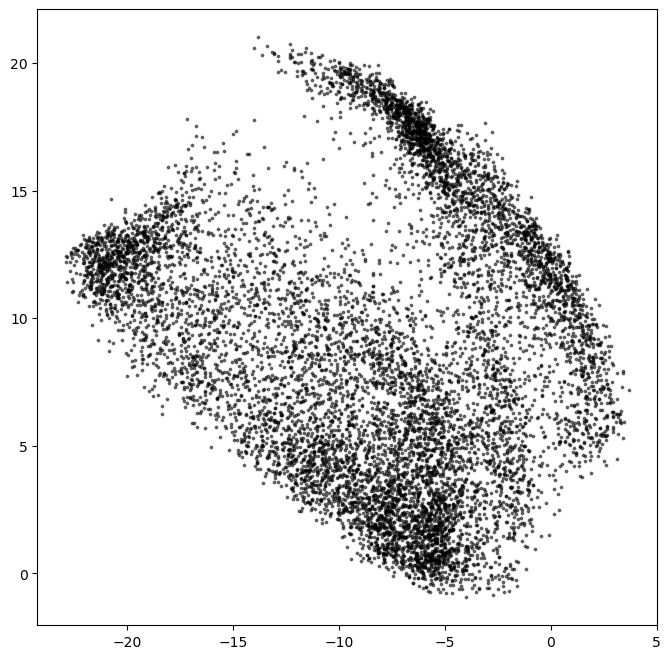

In [20]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

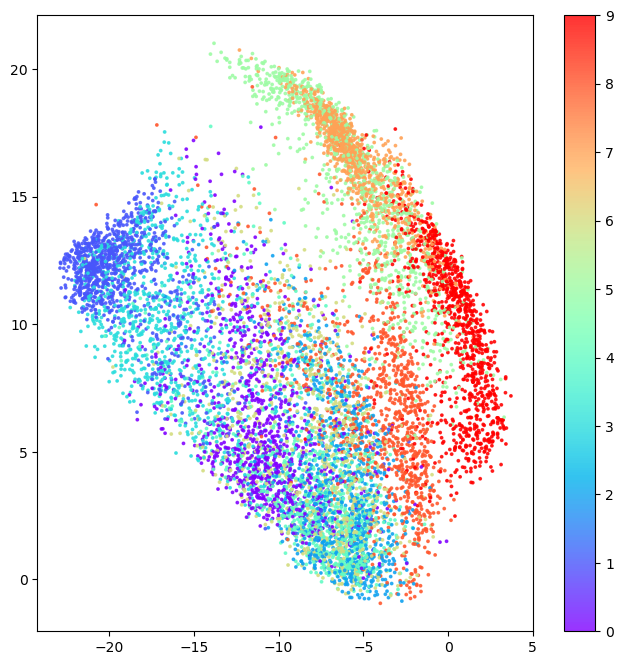

In [21]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=test_label,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

In [22]:
mins, _ = torch.min(embeddings, dim=0)
maxs, _ = torch.max(embeddings, dim=0)
mins, maxs

(tensor([-22.9057,  -0.9327]), tensor([ 3.7095, 21.0055]))

In [23]:
grid_width, grid_height = (8, 8)
sample = (maxs - mins) * torch.rand(64, 2) + mins


In [24]:
with torch.no_grad():
    reconstructions = model.decoder(sample.cuda()).cpu()


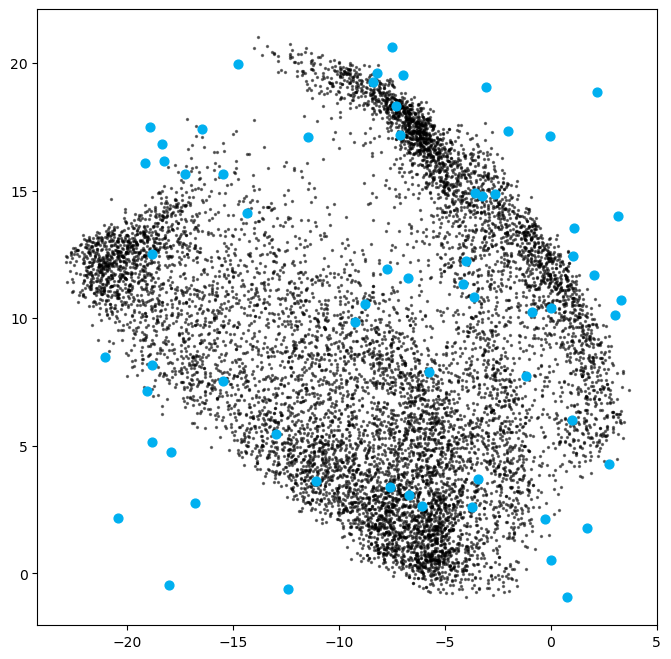

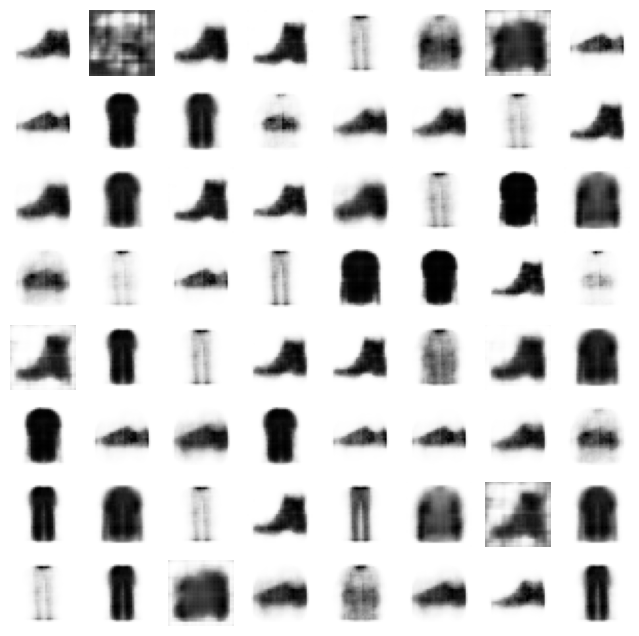

In [25]:
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height))

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i].squeeze(), cmap="Greys")

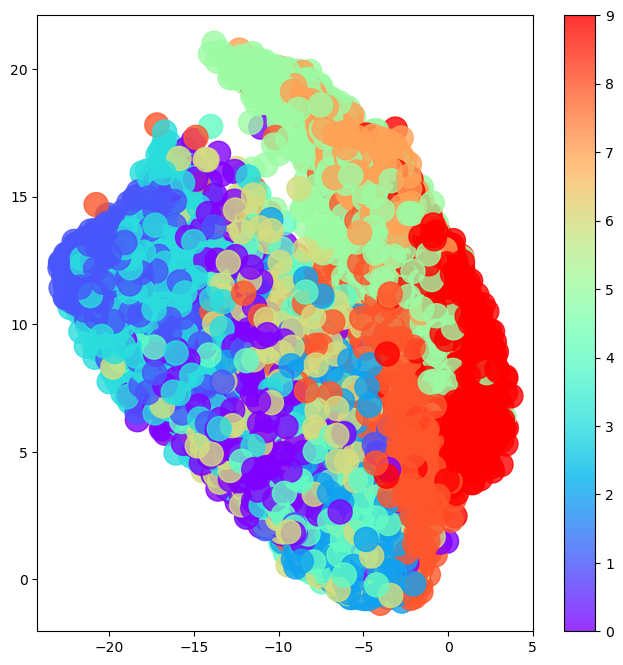

In [26]:
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=test_label,
    alpha=0.8,
    s=300,
)
plt.colorbar()
plt.show()

In [27]:
grid_size = 16

x = torch.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = torch.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = torch.meshgrid(x, y, indexing='ij')
xv = xv.flatten()
yv = yv.flatten()
grid = torch.stack((xv, yv), dim=1)

torch.Size([256, 2])

In [28]:
with torch.no_grad():
    reconstructions = model.decoder(grid.cuda()).cpu()

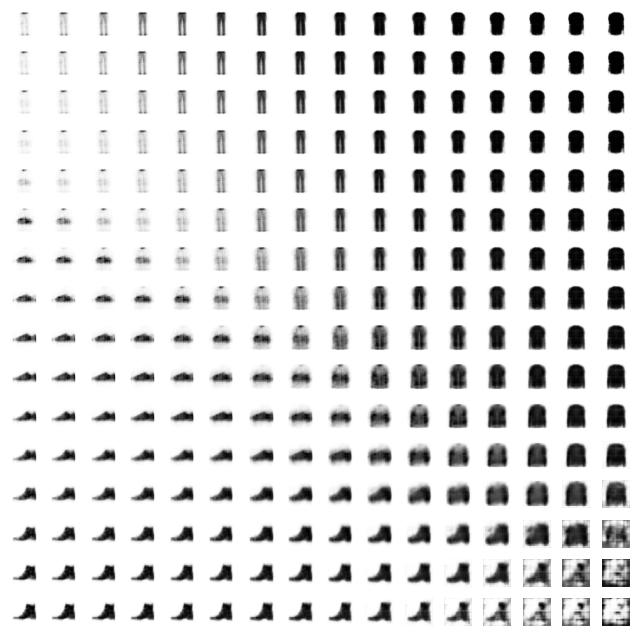

In [29]:
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i].squeeze(), cmap="Greys")